In [1]:
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg as gb
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from nltk import word_tokenize, sent_tokenize 
import pandas as pd

古腾堡语料库 NLTK包含古腾堡项目（Project Gutenberg）电子文档的一小部分文本。 该项目大约有25000（现在是36000）本免费电子书。 我们通过平均句子长度和平均词种数（词语丰富度）这两个特征，来看不同作者的写作风格。

NLTK的古腾堡语料库收集的都是不同作家的书

In [2]:
nltk.download('gutenberg')
nltk.download('punkt')
#nltk.download('movie_reviews')#电影评论
#nltk.download('webtext') #网络和聊天文本
from nltk.corpus import gutenberg
from nltk.corpus import webtext
from nltk.corpus import movie_reviews
#print(gutenberg.fileids())
hamlet = gutenberg.words('shakespeare-hamlet.txt')  # 获取shakespeare-hamlet.txt这个文件的单词
print(hamlet)
hamlets = gutenberg.sents('shakespeare-hamlet.txt')  # 获取shakespeare-hamlet.txt这个文件的句子
print(hamlets)
send_table = [] # 得到text的二维str数组
text_string = '' # text纯string表示
p = ''',.";:'?()[]!`'''
data_source = gutenberg
for text_id in data_source.fileids()[0:2]:
    unit = data_source.sents(text_id)
    for s in unit:
        sent = []
        sent.append('<s')
        for word in s:
            if len(word)==1 and word in p:
                continue #在此增加if条件可以去除停用词等
            word = word.lower()
            sent.append(word)
            text_string+=word+' '
        sent.append('/s>')
        send_table.append(sent)

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/wofeishenling/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wofeishenling/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['[', 'The', 'Tragedie', 'of', 'Hamlet', 'by', ...]
[['[', 'The', 'Tragedie', 'of', 'Hamlet', 'by', 'William', 'Shakespeare', '1599', ']'], ['Actus', 'Primus', '.'], ...]


In [ ]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    # Testing whether it works. 
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize

In [ ]:
import os
import requests
import io #codecs


# Text version of https://kilgarriff.co.uk/Publications/2005-K-lineer.pdf
if os.path.isfile('language-never-random.txt'):
    with io.open('language-never-random.txt', encoding='utf8') as fin:
        text = fin.read()
else:
    url = "https://gist.githubusercontent.com/alvations/53b01e4076573fea47c6057120bb017a/raw/b01ff96a5f76848450e648f35da6497ca9454e4a/language-never-random.txt"
    text = requests.get(url).content.decode('utf8')
    with io.open('language-never-random.txt', 'w', encoding='utf8') as fout:
        fout.write(text)

In [ ]:
# Tokenize the text.
tokenized_text = [list(map(str.lower, word_tokenize(sent))) 
                  for sent in sent_tokenize(text)]

In [5]:
import string
sent_t = []
for w_l in tokenized_text:
    sent_t.append(' '.join(w_l).replace(',','').replace('- ','').replace('.','').replace('  ',' '))
d = {'sentence':sent_t}
sent_table = pd.DataFrame(d)
sent_list = []
for sent in sent_table['sentence']:
    w_list = []
    for word in sent.split(' '):
        w_list.append(str(word))
    sent_list.append(w_list)
sent_table.head()

NameError: name 'tokenized_text' is not defined

In [3]:
word_list =[n for a in send_table for n in a]
word_set=set(word_list)

In [13]:
# 对text_string进行词频统计
word_list = []
cnt_list = []
text_tokenized = nltk.word_tokenize(text_string)
#print(text_tokenized)   
from nltk import FreqDist
fdist = FreqDist(text_tokenized)
print(fdist)
for a,b in fdist.items():
    word_list.append(str(a))
    cnt_list.append(b)
dic = {
    'word':word_list,
    'cnt':cnt_list
}
info_table = pd.DataFrame(dic)
info_table.head(10)

<FreqDist with 9053 samples and 258239 outcomes>


,word,cnt
0,emma,866
1,by,989
2,jane,302
3,austen,2
4,1816,1
5,volume,7
6,i,4302
7,chapter,80
8,woodhouse,313
9,handsome,57


In [14]:
# Preprocess the tokenized text for 3-grams language modelling
# send_table: list[list(str)]
from nltk.lm.preprocessing import padded_everygram_pipeline
n = 3
train_data, padded_sents = padded_everygram_pipeline(n, send_table)

In [15]:
# 使用nltk 的ngram模型
from nltk.lm import MLE
model = MLE(n) # Lets train a 3-grams model, previously we set n=3

In [16]:
model.fit(train_data, padded_sents)
print(model.vocab)

<Vocabulary with cutoff=1 unk_label='<UNK>' and 9125 items>


In [17]:
model.logscore('william',['hamlet','by'])

-inf

In [77]:
word2sum = {}
word_set = set()
for sent in send_table:
    w1=''
    w2=''
    for word in sent:
        if w2 == '':
            log_prob = -model.logscore(word)
        elif w1 == '':
            log_prob = -model.logscore(word,[w2])
        else:
            log_prob = -model.logscore(word,[w1,w2])
        print(log_prob)
        if word in word2sum:
            word2sum[word] += log_prob
        else:
            word2sum[word] = 0
        w1 = w2
        w2 = word

4.808600049502064


KeyboardInterrupt: 

In [19]:
#增加词长、计算信息量
word_count_table = pd.DataFrame()
for n,word in enumerate(info_table['word']):
    # Create a list of just the word we are interested in, we use regular expressions so that part of words do not count
    # e.g. 'ear' would be counted in each appearance of the word 'year'
    word_count = len(word)  
    word_count_table = word_count_table.append(pd.DataFrame({'len':word_count}, index=[n]))
info_table['len'] = word_count_table['len']
sum_table = pd.DataFrame()
for n,word in enumerate(info_table['word']):
    if word not in word2sum:
        sum_table = sum_table.append(pd.DataFrame({'sum':-1}, index=[n]))
        continue
    sum_proc = word2sum[word]
    sum_table = sum_table.append(pd.DataFrame({'sum':sum_proc}, index=[n]))
info_table['sum_neg_log_prob'] = sum_table['sum']
info_table['averge_content'] = (info_table['sum_neg_log_prob']/info_table['cnt'])
info_table.head(30)

,word,cnt,len,sum_neg_log_prob,averge_content
0,emma,866,4,2718.945080,3.139659
1,by,989,2,1612.443231,1.630377
2,jane,302,4,1015.868815,3.363804
3,austen,2,6,0.584963,0.292481
4,1816,1,4,0.000000,0.000000
5,volume,7,6,42.713527,6.101932
6,i,4302,1,10218.978611,2.375402
7,chapter,80,7,569.154321,7.114429
8,woodhouse,313,9,540.679192,1.727410
9,handsome,57,8,253.994002,4.456035


In [75]:
info_table = info_table[info_table['len']<15]
info_table = info_table[info_table['cnt']>20]
info_table = info_table[info_table['averge_content']>0.5]
info_table.intent = ['len','averge_content']
info_table.head()


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [76]:
print (vis.to_matplotlib())

import matplotlib.pyplot as plt
plt.rcParams.update(
            {
                "axes.titlesize": 20,
                "axes.titleweight": "bold",
                "axes.labelweight": "bold",
                "axes.labelsize": 16,
                "legend.fontsize": 14,
                "legend.title_fontsize": 15,
                "xtick.labelsize": 13,
                "ytick.labelsize": 13,
            }
        )
import numpy as np
from math import nan
df = pd.DataFrame({'len': {2: 3, 3: 4, 4: 5, 1: 2, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 16: 17}, 'averge_content': {2: 2.266593459560208, 3: 2.075021459804718, 4: 2.048427040407961, 1: 1.8724707505277598, 5: 1.848061385404622, 6: 1.7012359464850482, 7: 1.5851396407974498, 8: 1.537666801269923, 9: 1.4424778593465934, 16: 1.3016868177187297}})
fig, ax = plt.subplots()
bars = df['len']
measurements = df['averge_content']
ax.barh(2      3
3      4
4      5
1      2
5      6
6      7
7      8
8      9
9     10
16    17
Name: len, dtype: object, 2  

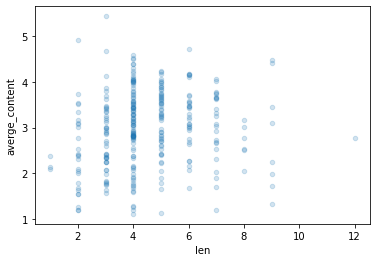

In [74]:
info_table.plot.scatter(x="len", y="averge_content",alpha=0.2)
#plt.savefig('./webtext_ALL_300dpi.jpg', bbox_inches='tight', dpi=300)
long_word = list(info_table[info_table['len']>10]['word'])

In [36]:
info_table.to_csv('./info_csv')
import lux
df = pd.read_csv('./info_csv')
from lux.vis.Vis import Vis
intent = ['averge_content',"len"]
vis = Vis(intent,df)
vis

LuxWidget(current_vis={'config': {'view': {'continuousWidth': 400, 'continuousHeight': 300}, 'axis': {'labelCo…